In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# Make the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [76]:
# build the dataset
block_size = 3 # lenght of content
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # shift window of context to right

X = torch.tensor(X)
Y = torch.tensor(Y)    

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [6]:
C = torch.randn((27,2)) # make a look up table for character embedding

In [7]:
C

tensor([[-0.1035, -1.0218],
        [-2.4636, -0.8602],
        [-0.1369, -0.3036],
        [-0.0293,  1.1017],
        [-1.3637, -1.2425],
        [-1.3325, -0.3902],
        [ 0.7457,  0.4349],
        [-0.9026, -0.2926],
        [ 0.5834,  0.3665],
        [ 0.1861,  1.6604],
        [-0.0287, -0.1682],
        [ 0.5282,  0.4704],
        [ 0.4718,  0.5768],
        [ 0.0332,  0.6434],
        [ 0.6174,  1.2221],
        [ 0.5164, -1.0366],
        [ 1.4174, -0.2807],
        [ 1.9889,  1.6753],
        [-1.5435, -1.2478],
        [ 0.8139, -0.6817],
        [-1.0302, -0.9691],
        [ 0.5120, -0.8729],
        [-0.9179, -0.7688],
        [-0.3821,  0.9644],
        [ 1.4251,  0.1745],
        [ 0.2931, -1.2899],
        [ 0.1550,  0.8627]])

In [8]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [9]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [11]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [12]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [13]:
counts = logits.exp()
prob = counts/counts.sum(dim=1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [14]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.0107)

## -------------------------Make code readable-------------------------

In [16]:
# build the dataset

block_size = 3 # lenght of content
X, Y = [], []
for w in words:
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift window of context to right

X = torch.tensor(X)
Y = torch.tensor(Y)

In [17]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [57]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g) # make a look up table for character embedding
# make first layer
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
# Make second layer
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

In [58]:
sum(p.nelement() for p in parameters)

3481

In [59]:
for p in parameters:
    p.requires_grad = True

In [60]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [61]:
lri = []
lossi = []

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # foward pass
    emb = C[X[ix]]
    h = h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])  
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr*p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

18.2443904876709
20.37178611755371
19.634355545043945
18.10696792602539
17.324169158935547
17.325464248657227
18.269433975219727
17.485015869140625
19.846261978149414
17.933568954467773
16.18417739868164
18.739580154418945
21.8828182220459
17.480924606323242
18.92359161376953
21.15818214416504
16.76611328125
16.844297409057617
17.837251663208008
20.08112335205078
18.312049865722656
18.7435245513916
18.967252731323242
17.394071578979492
17.166351318359375
21.23149871826172
19.98619270324707
19.19268226623535
16.79128646850586
20.09031867980957
17.912187576293945
17.462657928466797
19.283855438232422
21.85262107849121
19.024673461914062
19.422122955322266
14.570027351379395
19.350048065185547
19.426054000854492
15.011188507080078
18.267805099487305
19.009075164794922
18.991573333740234
16.26455307006836
18.546100616455078
18.992820739746094
19.030935287475586
19.703920364379883
16.684823989868164
14.336382865905762
18.52764320373535
14.980633735656738
17.602306365966797
16.52190399169922

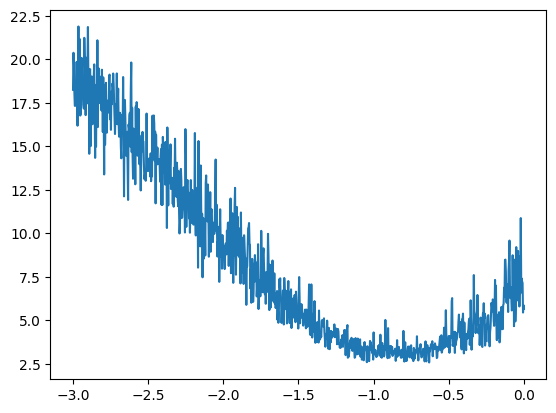

In [62]:
plt.plot(lri,lossi)

# Trick for finding good learning rate
1. Test extremely low and high lr to find reasonable range of lr (gradually decreasing loss) 
2. Create a list of lr ranging from the low-possible lr to high-possible lr with n value 
3. Start training with lowest one and step to next lr in the next training loop
4. Save the loss value for each loop
5. Plot loss for each lr to find the optimal one


# Train with optimal lr

In [106]:
# Data split: Training, dev/validation, Test set
def build_dataset(words):
    block_size = 3 # lenght of content
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix] # shift window of context to right
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)  
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182691, 3]) torch.Size([182691])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22662, 3]) torch.Size([22662])


In [177]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g) # make a look up table for character embedding
# make first layer
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
# Make second layer
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

In [178]:
sum(p.nelement() for p in parameters)

11897

In [179]:
for p in parameters:
    p.requires_grad = True

In [180]:
stepi = []
lossi = []

for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # foward pass
    emb = C[Xtr[ix]]
    h = h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])  
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item())

1.8249683380126953


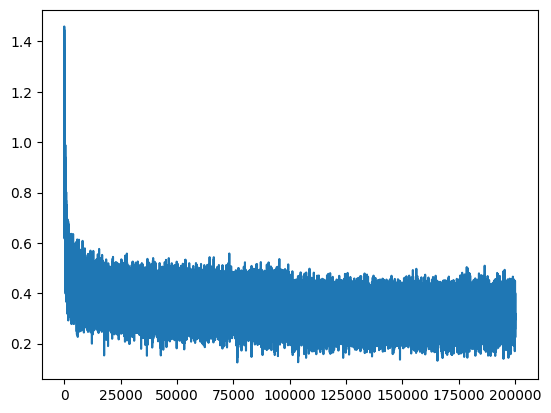

In [181]:
plt.plot(stepi,lossi)

In [182]:
emb = C[Xdev]
h = h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)  
loss

tensor(2.1670, grad_fn=<NllLossBackward0>)

In [183]:
emb = C[Xte]
h = h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)  
loss

tensor(2.1753, grad_fn=<NllLossBackward0>)

Visualize embedding

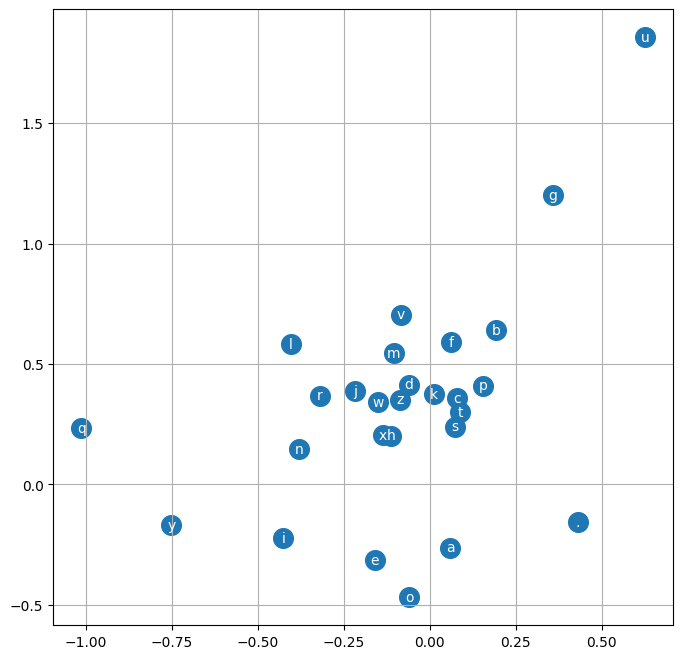

In [142]:
plt.figure(figsize=[8,8])
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [187]:
# sample
for _ in range(20):

    out = []
    blocksize = 3
    context = [0]*blocksize
    while True:
        emb = C[torch.tensor([context])]
        h = h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break

    print(''.join(itos[i] for i in out))

tymida.
crakl.
macianna.
elbigh.
jamey.
tahida.
safar.
gapharbri.
rissa.
ara.
ada.
ani.
drielloyah.
myaan.
bryn.
kaitis.
eva.
lawe.
dah.
thit.
